In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv("WELFake_Dataset.csv")

# Quick look
print(df.shape)
print(df.columns)
print(df.head())

(72134, 4)
Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64
label
1    0.514404
0    0.485596
Name: proportion, dtype: float64


<Axes: title={'center': 'Fake (0) vs Real (1)'}, xlabel='label'>

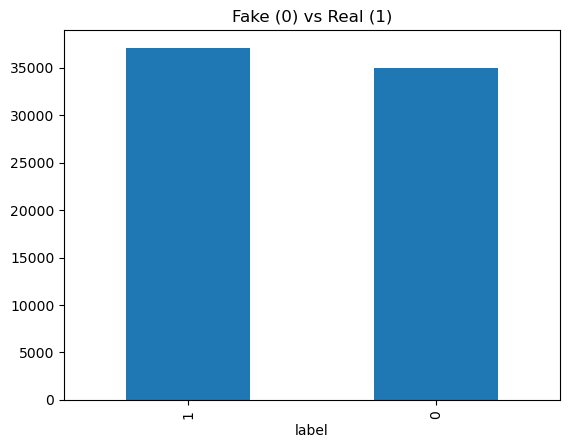

In [3]:
# Overview
print(df.info())

# Null value check
print(df.isnull().sum())

# Distribution of labels
print(df['label'].value_counts(normalize=True))  # Percentage
df['label'].value_counts().plot(kind='bar', title="Fake (0) vs Real (1)")


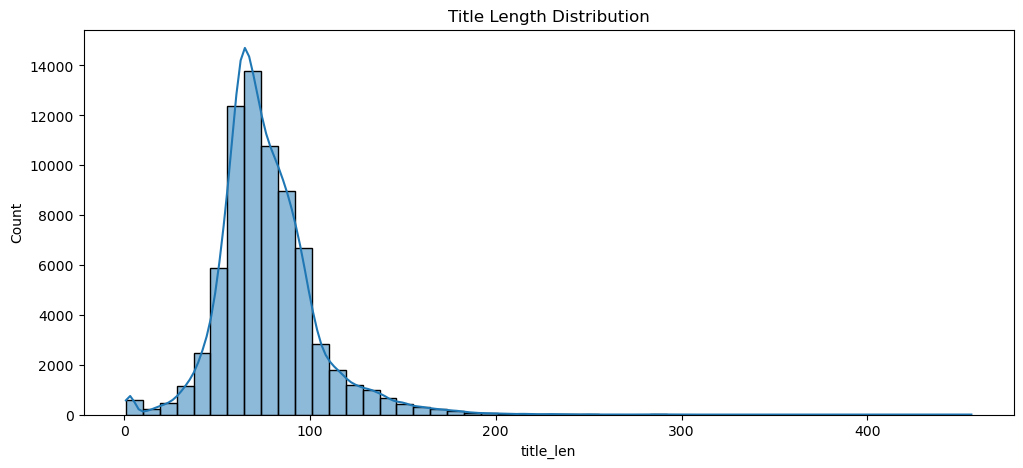

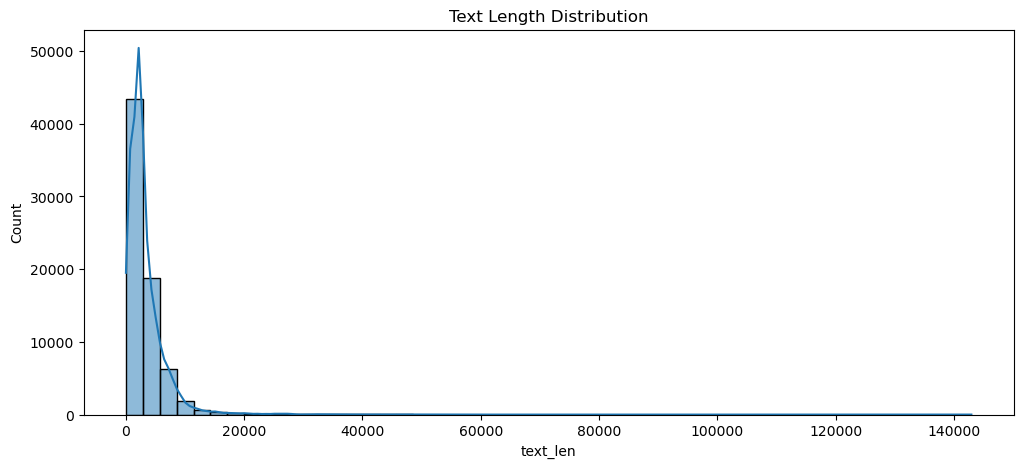

In [5]:

df['title_len'] = df['title'].astype(str).apply(len)
df['text_len'] = df['text'].astype(str).apply(len)
plt.figure(figsize=(12,5))
sns.histplot(data=df, x='title_len', bins=50, kde=True)
plt.title("Title Length Distribution")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(data=df, x='text_len', bins=50, kde=True)
plt.title("Text Length Distribution")
plt.show()

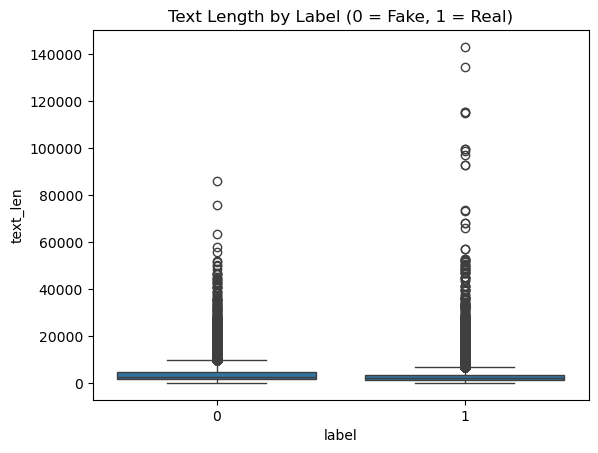

In [22]:
# Compare text lengths between fake and real news
sns.boxplot(x='label', y='text_len', data=df)
plt.title("Text Length by Label (0 = Fake, 1 = Real)")
plt.show()


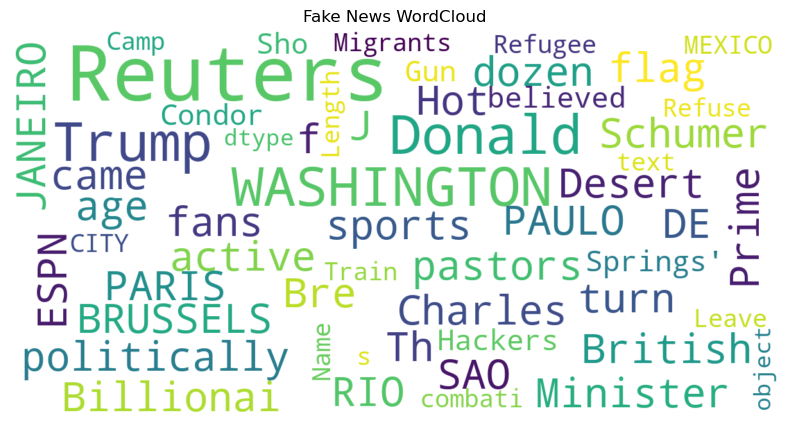

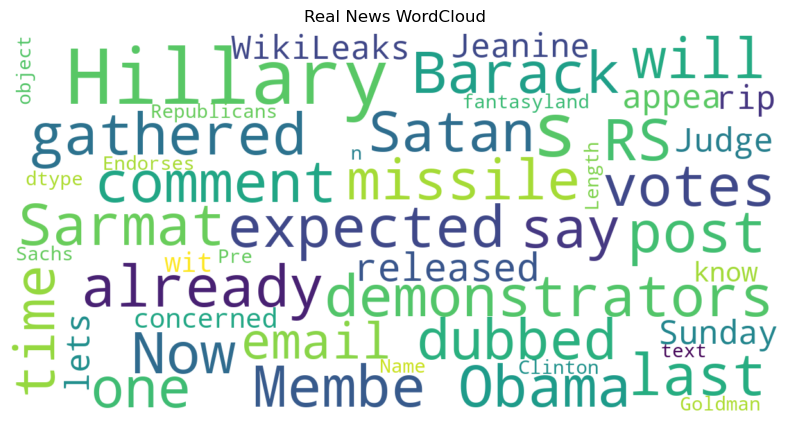

In [7]:
from wordcloud import WordCloud

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=42
    ).generate(str(data))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Wordclouds
show_wordcloud(df[df['label']==0]['text'], title="Fake News WordCloud")
show_wordcloud(df[df['label']==1]['text'], title="Real News WordCloud")


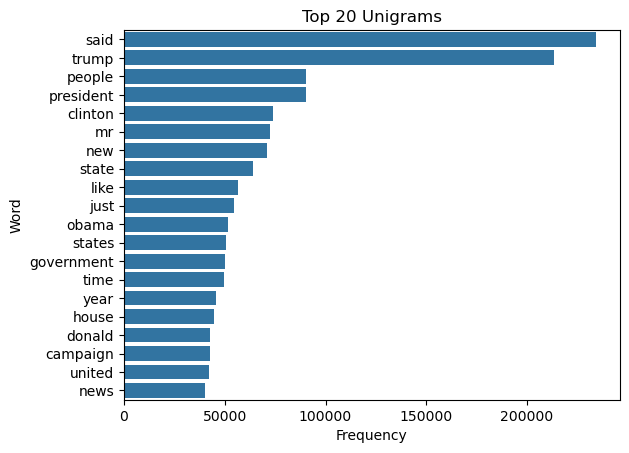

In [8]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Top unigrams
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'].astype(str))
sum_words = X.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# Show top 20
top_words = pd.DataFrame(words_freq[:20], columns=['Word', 'Frequency'])
sns.barplot(data=top_words, x='Frequency', y='Word')
plt.title("Top 20 Unigrams")
plt.show()


In [25]:
import re

def preprocess(text):
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

df['processed_text'] = (df['title'].fillna('') + ' ' + df['text'].fillna('')).apply(preprocess)


In [12]:
from sklearn.model_selection import train_test_split

X = df['processed_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [15]:
# -----------------------------------------------
# 4. TF-IDF Vectorization
# -----------------------------------------------
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [16]:
# -----------------------------------------------
# 5. Train Logistic Regression Model
# -----------------------------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [17]:
# -----------------------------------------------
# 6. Evaluate the Model
# -----------------------------------------------
y_pred = model.predict(X_test_tfidf)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\nAccuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))


Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7006
           1       0.95      0.96      0.95      7421

    accuracy                           0.95     14427
   macro avg       0.95      0.95      0.95     14427
weighted avg       0.95      0.95      0.95     14427


Accuracy: 95.11%


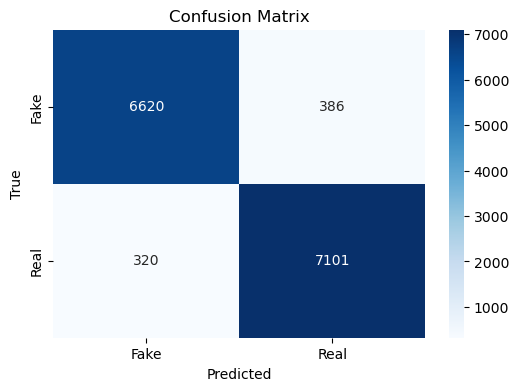

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Time for LSTM

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load and Preprocess Data
# ----------------------------
df = pd.read_csv("WELFake_Dataset.csv")
df['combined'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

def clean(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

df['clean'] = df['combined'].apply(clean)

# ----------------------------
# 2. Tokenization (basic word-level)
# ----------------------------
def tokenize(text):
    return text.split()

df['tokens'] = df['clean'].apply(tokenize)

# Build vocabulary
all_words = [word for tokens in df['tokens'] for word in tokens]
word_freq = Counter(all_words)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_freq.most_common(50000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Convert tokens to indices
def encode(tokens):
    return [vocab.get(word, vocab['<UNK>']) for word in tokens]

df['input_ids'] = df['tokens'].apply(encode)

# Pad sequences
MAX_LEN = 300
def pad_sequence(seq):
    return seq[:MAX_LEN] + [0] * (MAX_LEN - len(seq)) if len(seq) < MAX_LEN else seq[:MAX_LEN]

df['padded'] = df['input_ids'].apply(pad_sequence)

# ----------------------------
# 3. Dataset and DataLoader
# ----------------------------
class FakeNewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_test, y_train, y_test = train_test_split(df['padded'].tolist(), df['label'], test_size=0.2, stratify=df['label'])

train_dataset = FakeNewsDataset(X_train, y_train)
test_dataset = FakeNewsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# ----------------------------
# 4. Define the LSTM Model
# ----------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        hidden = lstm_out[:, -1, :]  # last hidden state
        output = self.fc(hidden)
        return self.sigmoid(output).squeeze(1)

# ----------------------------
# 5. Training Loop
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(vocab_size=len(vocab), embed_dim=100, hidden_dim=128).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

# ----------------------------
# 6. Evaluation
# ----------------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = (outputs > 0.5).int().cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"\n✅ LSTM Test Accuracy: {acc * 100:.2f}%")
print(f"✅ F1 Score: {f1:.4f}")


Epoch 1/5: 100%|██████████████████████████████| 902/902 [00:10<00:00, 84.42it/s]


Epoch 1 Loss: 0.6174


Epoch 2/5: 100%|██████████████████████████████| 902/902 [00:10<00:00, 87.92it/s]


Epoch 2 Loss: 0.4417


Epoch 3/5: 100%|██████████████████████████████| 902/902 [00:10<00:00, 87.43it/s]


Epoch 3 Loss: 0.1529


Epoch 4/5: 100%|██████████████████████████████| 902/902 [00:10<00:00, 87.15it/s]


Epoch 4 Loss: 0.0728


Epoch 5/5: 100%|██████████████████████████████| 902/902 [00:10<00:00, 86.61it/s]


Epoch 5 Loss: 0.0432

✅ LSTM Test Accuracy: 97.05%
✅ F1 Score: 0.9712


In [ ]:
# BERT

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Using PyTorch's native AdamW
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd
import re
from tqdm import tqdm

# ----------------------------
# 1. Load and Preprocess Data
# ----------------------------
df = pd.read_csv("WELFake_Dataset.csv")
df['combined'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

def clean(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

df['clean'] = df['combined'].apply(clean)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

# ----------------------------
# 2. BERT Tokenization
# ----------------------------
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 256  # Optimal length for efficiency

def tokenize_and_encode(texts, labels, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return {
        'input_ids': torch.cat(input_ids, dim=0),
        'attention_masks': torch.cat(attention_masks, dim=0),
        'labels': torch.tensor(labels.values, dtype=torch.long)
    }

train_encodings = tokenize_and_encode(X_train, y_train)
test_encodings = tokenize_and_encode(X_test, y_test)

# ----------------------------
# 3. Dataset Class
# ----------------------------
class FakeNewsBERTDataset(Dataset):
    def __init__(self, encodings):
        self.input_ids = encodings['input_ids']
        self.attention_masks = encodings['attention_masks']
        self.labels = encodings['labels']
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }
    
    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsBERTDataset(train_encodings)
test_dataset = FakeNewsBERTDataset(test_encodings)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# ----------------------------
# 4. BERT Model Definition
# ----------------------------
class BERTFakeNewsClassifier(nn.Module):
    def __init__(self):
        super(BERTFakeNewsClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return self.sigmoid(logits).squeeze(1)

# ----------------------------
# 5. Training Setup
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTFakeNewsClassifier().to(device)

# Using PyTorch's AdamW with same parameters as before
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()

# ----------------------------
# 6. Training Loop
# ----------------------------
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# ----------------------------
# 7. Evaluation Function
# ----------------------------
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (outputs > 0.5).int()
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    report = classification_report(true_labels, predictions)
    
    return accuracy, f1, report

# ----------------------------
# 8. Run Training and Evaluation
# ----------------------------
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    
    accuracy, f1, report = evaluate(model, test_loader, device)
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)

# ----------------------------
# 9. Save the Model (optional)
# ----------------------------
# torch.save(model.state_dict(), 'bert_fake_news_classifier.pth')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



Epoch 1/5


Training: 100%|█████████████████████████████| 3607/3607 [48:51<00:00,  1.23it/s]


Training Loss: 0.0714


Evaluating: 100%|█████████████████████████████| 902/902 [04:15<00:00,  3.53it/s]



Test Accuracy: 99.04%
F1 Score: 0.9907

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7006
           1       0.99      0.99      0.99      7421

    accuracy                           0.99     14427
   macro avg       0.99      0.99      0.99     14427
weighted avg       0.99      0.99      0.99     14427


Epoch 2/5


Training: 100%|█████████████████████████████| 3607/3607 [48:53<00:00,  1.23it/s]


Training Loss: 0.0214


Evaluating: 100%|█████████████████████████████| 902/902 [04:15<00:00,  3.53it/s]



Test Accuracy: 98.73%
F1 Score: 0.9876

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7006
           1       1.00      0.98      0.99      7421

    accuracy                           0.99     14427
   macro avg       0.99      0.99      0.99     14427
weighted avg       0.99      0.99      0.99     14427


Epoch 3/5


Training: 100%|█████████████████████████████| 3607/3607 [48:56<00:00,  1.23it/s]


Training Loss: 0.0126


Evaluating: 100%|█████████████████████████████| 902/902 [04:14<00:00,  3.54it/s]



Test Accuracy: 99.15%
F1 Score: 0.9918

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7006
           1       0.99      0.99      0.99      7421

    accuracy                           0.99     14427
   macro avg       0.99      0.99      0.99     14427
weighted avg       0.99      0.99      0.99     14427


Epoch 4/5


Training: 100%|█████████████████████████████| 3607/3607 [48:59<00:00,  1.23it/s]


Training Loss: 0.0086


Evaluating: 100%|█████████████████████████████| 902/902 [04:14<00:00,  3.54it/s]



Test Accuracy: 99.09%
F1 Score: 0.9912

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7006
           1       0.99      0.99      0.99      7421

    accuracy                           0.99     14427
   macro avg       0.99      0.99      0.99     14427
weighted avg       0.99      0.99      0.99     14427


Epoch 5/5


Training: 100%|█████████████████████████████| 3607/3607 [48:54<00:00,  1.23it/s]


Training Loss: 0.0071


Evaluating: 100%|█████████████████████████████| 902/902 [04:14<00:00,  3.54it/s]



Test Accuracy: 99.18%
F1 Score: 0.9920

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7006
           1       1.00      0.99      0.99      7421

    accuracy                           0.99     14427
   macro avg       0.99      0.99      0.99     14427
weighted avg       0.99      0.99      0.99     14427



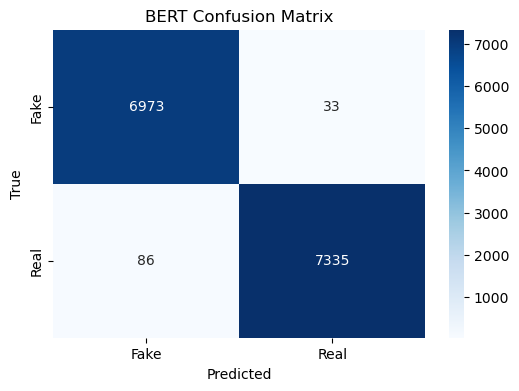

              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99      7006
        Real       1.00      0.99      0.99      7421

    accuracy                           0.99     14427
   macro avg       0.99      0.99      0.99     14427
weighted avg       0.99      0.99      0.99     14427



In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# First run evaluation to get the predictions and true labels
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = (outputs > 0.5).int()
        
        all_predictions.extend(preds.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Now create the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Confusion Matrix')
plt.show()

# Print classification report again for reference
print(classification_report(all_true_labels, all_predictions, target_names=['Fake', 'Real']))

In [48]:
# 9. Save the Model (optional)
# ----------------------------
torch.save(model.state_dict(), 'bert_fake_news_classifier.pth')